In [1]:
import numpy as np
import pandas as pd

import string

import matplotlib.pyplot as plt
import cv2

import tensorflow 
from tensorflow import keras

# fonctions de récupération et préparation des données
import traintestsplit as tts
from words_txt_to_df import txt_to_df
from nettoyage_fichiers import clean_data, error_image
from harmonisation import harmony_clean
from keep_n_chars import max_n_chars

# Générateur de batchs
from  generator_rnn import DatasetGenerator

# Modèlisation
import rnn_model

# Décodage
import rnn_pred 

import evaluation

# Reproductibilité
from numpy.random import seed
seed(64)
from tensorflow import random
random.set_seed(8)

Init Plugin
Init Graph Optimizer
Init Kernel


# Récupération des données et du modèle

In [2]:
print("Lecture de words.txt et transformation en dataframe") 
#[word_id,ok_err,gray_level,transcript,data_path]
df_words = txt_to_df('words.txt')

print("Suppression des erreurs de lecture d'image du df")
df_words = clean_data(df_words)

print("génération d'un dataframe contenant la répartition du dataset [line_id,set]")
df_tts = tts.text_to_splitDataframe()

print("Split des données")
trainset, testset, validationset = tts.split_data(df_tts, df_words)
    
# Variables utiles
BATCH_SIZE = 100 # 32 par défaut
TARGET_SIZE = (128,32) 
MAX_LENGTH = 10 # 21 par défaut
    
# Suppression des mots plus longs que MAX_LENGTH 
trainset = max_n_chars(trainset, MAX_LENGTH)
testset = max_n_chars(testset, MAX_LENGTH)
validationset = max_n_chars(validationset, MAX_LENGTH)
    
# Préparation des données
print("Préparation des données")
    
# Tranformation des images par lots
train_generator = DatasetGenerator(dataframe=trainset,
                                   directory="",
                                   x_col = "data_path",
                                   y_col = "transcript",
                                   targetSize = TARGET_SIZE,
                                   nb_canaux = 1, # images grayscale par défaut
                                   batchSize = BATCH_SIZE,
                                   shuffle = False,
                                   max_y_length = MAX_LENGTH)

# Idem pour le jeu de validation
valid_generator = DatasetGenerator(dataframe=validationset,
                                   x_col = "data_path",
                                   y_col = "transcript", 
                                   targetSize = TARGET_SIZE,  
                                   shuffle = False, 
                                   max_y_length = MAX_LENGTH)

# Et le jeu de test
test_generator = DatasetGenerator(dataframe=testset,
                                  x_col = "data_path",
                                  y_col = "transcript", 
                                  targetSize = TARGET_SIZE,  
                                  shuffle = False, 
                                  max_y_length = MAX_LENGTH)
    
print("Construction du modèle")
rnn = rnn_model.build_model_rnn(TARGET_SIZE)

rnn.load_weights('rnn.weights.h5')


Lecture de words.txt et transformation en dataframe
Suppression des erreurs de lecture d'image du df
Erreur de lecture sur l'image: a01-117-05-02.png
Erreur de lecture sur l'image: r06-022-03-05.png
génération d'un dataframe contenant la répartition du dataset [line_id,set]
Split des données
Préparation des données
Construction du modèle
Metal device set to: Apple M1


2021-12-16 13:04:21.327557: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-16 13:04:21.327643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "rnn2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_im (InputLayer)           [(None, 32, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 16, 64, 64)   5248        input_im[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 64, 64)   256         conv_1[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 64, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________________

# Prédictions sur les données test

In [3]:
predictions = rnn.predict(test_generator)
pred_key = rnn_pred.pred_top5(predictions, MAX_LENGTH)
df_top5 = rnn_pred.df_bilan_top5(testset, pred_key)
df_top5.head()

2021-12-16 13:04:21.648143: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-16 13:04:21.648265: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-16 13:04:21.811182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/sophieamedro/Desktop/PenPyText/rnn_pred.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top5_rnn[top5_rnn.columns[t]][i] = ''.join(mot)
/opt/homebrew/Caskroom/miniforge/base/envs/m1tf/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

,data_path,predict_1,predict_2,predict_3,predict_4,predict_5
0,data/words/m01/m01-049/m01-049-00-00.png,He,Hhe,tHe,Hre,te
1,data/words/m01/m01-049/m01-049-00-01.png,lie,lile,Wie,Kie,Wile
2,data/words/m01/m01-049/m01-049-00-02.png,frm,frn,firm,form,frem
3,data/words/m01/m01-049/m01-049-00-03.png,his,hns,hs,hi,hms
4,data/words/m01/m01-049/m01-049-00-05.png,Wek,Lek,Wak,lek,Lak


# Evaluation du modèle

## première prédiction

In [4]:
df_top5['transcript'] = testset.transcript
df_top5['transcript_is_pred1'] = None

for i in range(df_top5.shape[0]):
    df_top5.transcript_is_pred1[i] = evaluation.transcript_in_pred1(df_top5, i)
df_top5.head()

,data_path,predict_1,predict_2,predict_3,predict_4,predict_5,transcript,transcript_is_pred1
0,data/words/m01/m01-049/m01-049-00-00.png,He,Hhe,tHe,Hre,te,He,True
1,data/words/m01/m01-049/m01-049-00-01.png,lie,lile,Wie,Kie,Wile,rose,False
2,data/words/m01/m01-049/m01-049-00-02.png,frm,frn,firm,form,frem,from,False
3,data/words/m01/m01-049/m01-049-00-03.png,his,hns,hs,hi,hms,his,True
4,data/words/m01/m01-049/m01-049-00-05.png,Wek,Lek,Wak,lek,Lak,bench,False


In [5]:
df_top5["transcript_is_pred1"].value_counts(normalize = True)

False    0.567334
True     0.432666
Name: transcript_is_pred1, dtype: float64

## 5 meilleures prédictions 

In [6]:
df_top5['transcript_in_top5'] = None

for i in range(df_top5.shape[0]):
    df_top5.transcript_in_top5[i] = evaluation.transcript_in_top5(df_top5, i)
df_top5.head()

,data_path,predict_1,predict_2,predict_3,predict_4,predict_5,transcript,transcript_is_pred1,transcript_in_top5
0,data/words/m01/m01-049/m01-049-00-00.png,He,Hhe,tHe,Hre,te,He,True,True
1,data/words/m01/m01-049/m01-049-00-01.png,lie,lile,Wie,Kie,Wile,rose,False,False
2,data/words/m01/m01-049/m01-049-00-02.png,frm,frn,firm,form,frem,from,False,False
3,data/words/m01/m01-049/m01-049-00-03.png,his,hns,hs,hi,hms,his,True,True
4,data/words/m01/m01-049/m01-049-00-05.png,Wek,Lek,Wak,lek,Lak,bench,False,False


In [7]:
df_top5["transcript_in_top5"].value_counts(normalize = True)

True     0.52866
False    0.47134
Name: transcript_in_top5, dtype: float64

**Le modèle RNN**

# Visualisation

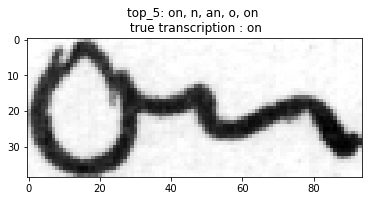

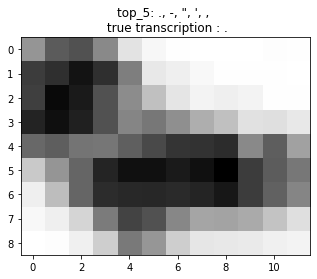

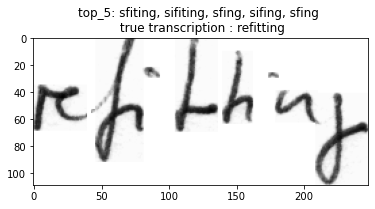

In [8]:
evaluation.viz_pred5(df_top5)

# CER

In [9]:
mean_cer_pred1 = df_top5.apply(evaluation.cer, axis = 1).mean()

In [10]:
mean_cer_pred1

0.3653907688766114

**La CER moyenne sur la première prédiction est de 0.36, ce qui nous indique que plus de 60% des caractères individuels sont correctement prédits.** 